In [5]:
import numpy as np
import scipy.signal as signal
import librosa
import librosa.display
import matplotlib.pyplot as plt
from scipy.fftpack import dct, idct
import math
import tensorflow.keras.layers as tfl
import tensorflow as tf
from keras.callbacks import ReduceLROnPlateau
from numpy.linalg import cond

In [6]:
def mfcc_to_vocal_tract_envelope_time_domain(signal, sr=44100, n_mfcc=120,epsilon=1e-10):
   # Calculate the appropriate n_fft based on the signal length
    signal_length = len(signal)
    n_fft = signal_length  # Use the entire signal length as n_fft
    
    # Compute MFCCs from the audio signal without windowing (single frame)
    mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=signal_length)
    
    # Flatten the MFCC to 1D array (n_mfcc,)
    mfcc = mfcc[:, 0]
    
    # Apply Inverse DCT to get back the log-power spectrum
    mfcc_dct = idct(mfcc, type=2, norm='ortho')
    
    # Convert back to the power spectrum (undo the logarithm)
    power_spectrum = np.exp(mfcc_dct)
    
    # Convert the power spectrum back to the time domain using the inverse FFT
    vocal_tract_envelope = np.fft.irfft(power_spectrum, n=n_fft)[:signal_length]
    
    # Normalize the vocal tract envelope
    vocal_tract_envelope = vocal_tract_envelope / np.max(np.abs(vocal_tract_envelope))
    
    # Step to extract the glottal pulse using deconvolution
    signal_fft = np.fft.rfft(signal, n=n_fft)
    envelope_fft = np.fft.rfft(vocal_tract_envelope, n=n_fft)
    
    # Avoid division by zero
    glottal_pulse_fft = signal_fft / (envelope_fft + epsilon)
    
    # Convert the glottal pulse back to the time domain
    glottal_pulse = np.fft.irfft(glottal_pulse_fft, n=n_fft)[:signal_length]
    
    # Normalize the glottal pulse
    glottal_pulse = glottal_pulse / np.max(np.abs(glottal_pulse))
    
    return vocal_tract_envelope, glottal_pulse

# 1) Glottal Impulse

In [7]:
def autocorrelation(signal):
    n = len(signal)
    mean = np.mean(signal)
    c = np.correlate(signal - mean, signal - mean, mode='full')
    return c[c.size // 2:]

In [8]:
def cross_correlation(x, y):
    n = len(x)
    # Zero-padding
    x_padded = np.pad(x, (0, n), mode='constant')
    y_padded = np.pad(y, (0, n), mode='constant')
    return np.correlate(x_padded, y_padded, mode='full')

In [12]:
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt

def plot_glottal_impulse(data_folder, num_speakers=5, num_utterances=5, frame_length_msec=10, inverse=False, sr=44100, iteration=1):
    total_speaker = 0
    for speaker in os.listdir(data_folder):
        print(f"Speaker number {total_speaker + 1}.\n")
        
        glottal_pulse = []
        vocal_pulse = []
        ori_pulse = []
        glottal_pulse_auto_corr=[]
        vt_pulse_auto_corr=[]
        glot_vt_ccf=[]
        
        y = []
        wav_files = os.listdir(os.path.join(data_folder, speaker))
        curr_time = 0
        req_time = num_utterances * frame_length_msec
        
        idx = 0
        while curr_time < req_time:
            if wav_files[idx].endswith(".wav"):
                wav_file_path = os.path.join(data_folder, speaker, wav_files[idx])
                y_curr, sr = librosa.load(wav_file_path, sr=sr)
                
                non_silent_intervals = librosa.effects.split(y_curr, top_db=15)
                y_non_silent = []
                begin = 0
                for start, end in non_silent_intervals:
                    if start - begin < (50 * sr // 1000):
                        y_non_silent.extend(y_curr[begin:start])
                    y_non_silent.extend(y_curr[start:end])
                    begin = start
                            
                y.extend(y_non_silent)
                curr_time = (len(y) * 1000 / sr)
                idx += 1
                                
        del wav_files
        
        frame_length_samples = frame_length_msec * sr // 1000
        frames = librosa.util.frame(np.array(y), frame_length=frame_length_samples, hop_length=frame_length_samples).T
        frames = frames[:num_utterances]
    
        if inverse:
            frames = [frame[::-1] for frame in frames]
        
        del y
        
        for frame in frames:
            v ,g = mfcc_to_vocal_tract_envelope_time_domain(frame)
            glottal_pulse.append(g)
            vocal_pulse.append(v)
            ori_pulse.append(frame/np.max(np.abs(frame)))
            glottal_pulse_auto_corr.append(autocorrelation(g))
            vt_pulse_auto_corr.append(autocorrelation(v))
            glot_vt_ccf.append(cross_correlation(g,v))
            
        
        fig, ax = plt.subplots(6 * num_utterances, 1, figsize=(20, 20))

        if num_utterances == 1:
            ax = [ax]
            
        for idx in range(num_utterances):
            t = np.arange(0, len(glottal_pulse[idx]) / sr, 1 / sr)

            ax[6 * idx].plot(t, glottal_pulse[idx])
            ax[6 * idx].set_xlabel('Time [s]')
            ax[6 * idx].set_ylabel('Amplitude')
            ax[6 * idx].set_title(f'Speaker : {speaker} Word : {idx + 1} Glottal Waveform')
            
            t = np.arange(0, len(vocal_pulse[idx]) / sr, 1 / sr)
            
            ax[6 * idx + 1].plot(t, vocal_pulse[idx])
            ax[6 * idx + 1].set_xlabel('Time [s]')
            ax[6 * idx + 1].set_ylabel('Amplitude')
            ax[6 * idx + 1].set_title(f'Speaker : {speaker} Word : {idx + 1} Vocal Tract Envelop')
            
            t = np.arange(0, len(vt_pulse_auto_corr[idx]) / sr, 1 / sr)
            
            ax[6 * idx + 2].plot(t, vt_pulse_auto_corr[idx]/np.max(np.abs(vt_pulse_auto_corr[idx])))
            ax[6 * idx + 2].set_xlabel('Time [s]')
            ax[6 * idx + 2].set_ylabel('Amplitude')
            ax[6 * idx + 2].set_title(f'Speaker : {speaker} Word : {idx + 1} Vocal Tract Envelop Auto-Corelation')
            
            t = np.arange(0, len(glottal_pulse_auto_corr[idx]) / sr, 1 / sr)
        
            ax[6 * idx + 3].plot(t, glottal_pulse_auto_corr[idx]/np.max(np.abs(glottal_pulse_auto_corr[idx])))
            ax[6 * idx + 3].set_xlabel('Time [s]')
            ax[6 * idx + 3].set_ylabel('Amplitude')
            ax[6 * idx + 3].set_title(f'Speaker : {speaker} Word : {idx + 1} Glottal Waveform Envelop Auto-Corelation')
            
            t = np.arange(0, len(glot_vt_ccf[idx]) / sr, 1 / sr)
            
            ax[6 * idx + 4].plot(t, glot_vt_ccf[idx]/np.max(np.abs(glot_vt_ccf[idx])))
            ax[6 * idx + 4].set_xlabel('Time [s]')
            ax[6 * idx + 4].set_ylabel('Amplitude')
            ax[6 * idx + 4].set_title(f'Speaker : {speaker} Word : {idx + 1} Glottal-Vocal Cross Correlation')
            
            t = np.arange(0, len(ori_pulse[idx]) / sr, 1 / sr)
            
            ax[6 * idx + 5].plot(t, ori_pulse[idx])
            ax[6 * idx + 5].set_xlabel('Time [s]')
            ax[6 * idx + 5].set_ylabel('Amplitude')
            ax[6 * idx + 5].set_title(f'Speaker : {speaker} Word : {idx + 1} Original')

        plt.tight_layout()
        plt.show()
                               
        total_speaker += 1

        if total_speaker == num_speakers:
            break


In [13]:
num_speakers=1
num_utterances=2
frame_length_msec=40
data_folder="/kaggle/input/speaker-recognition-audio-dataset/50_speakers_audio_data"

Speaker number 1.



[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1600) too large for available bit count (1568)


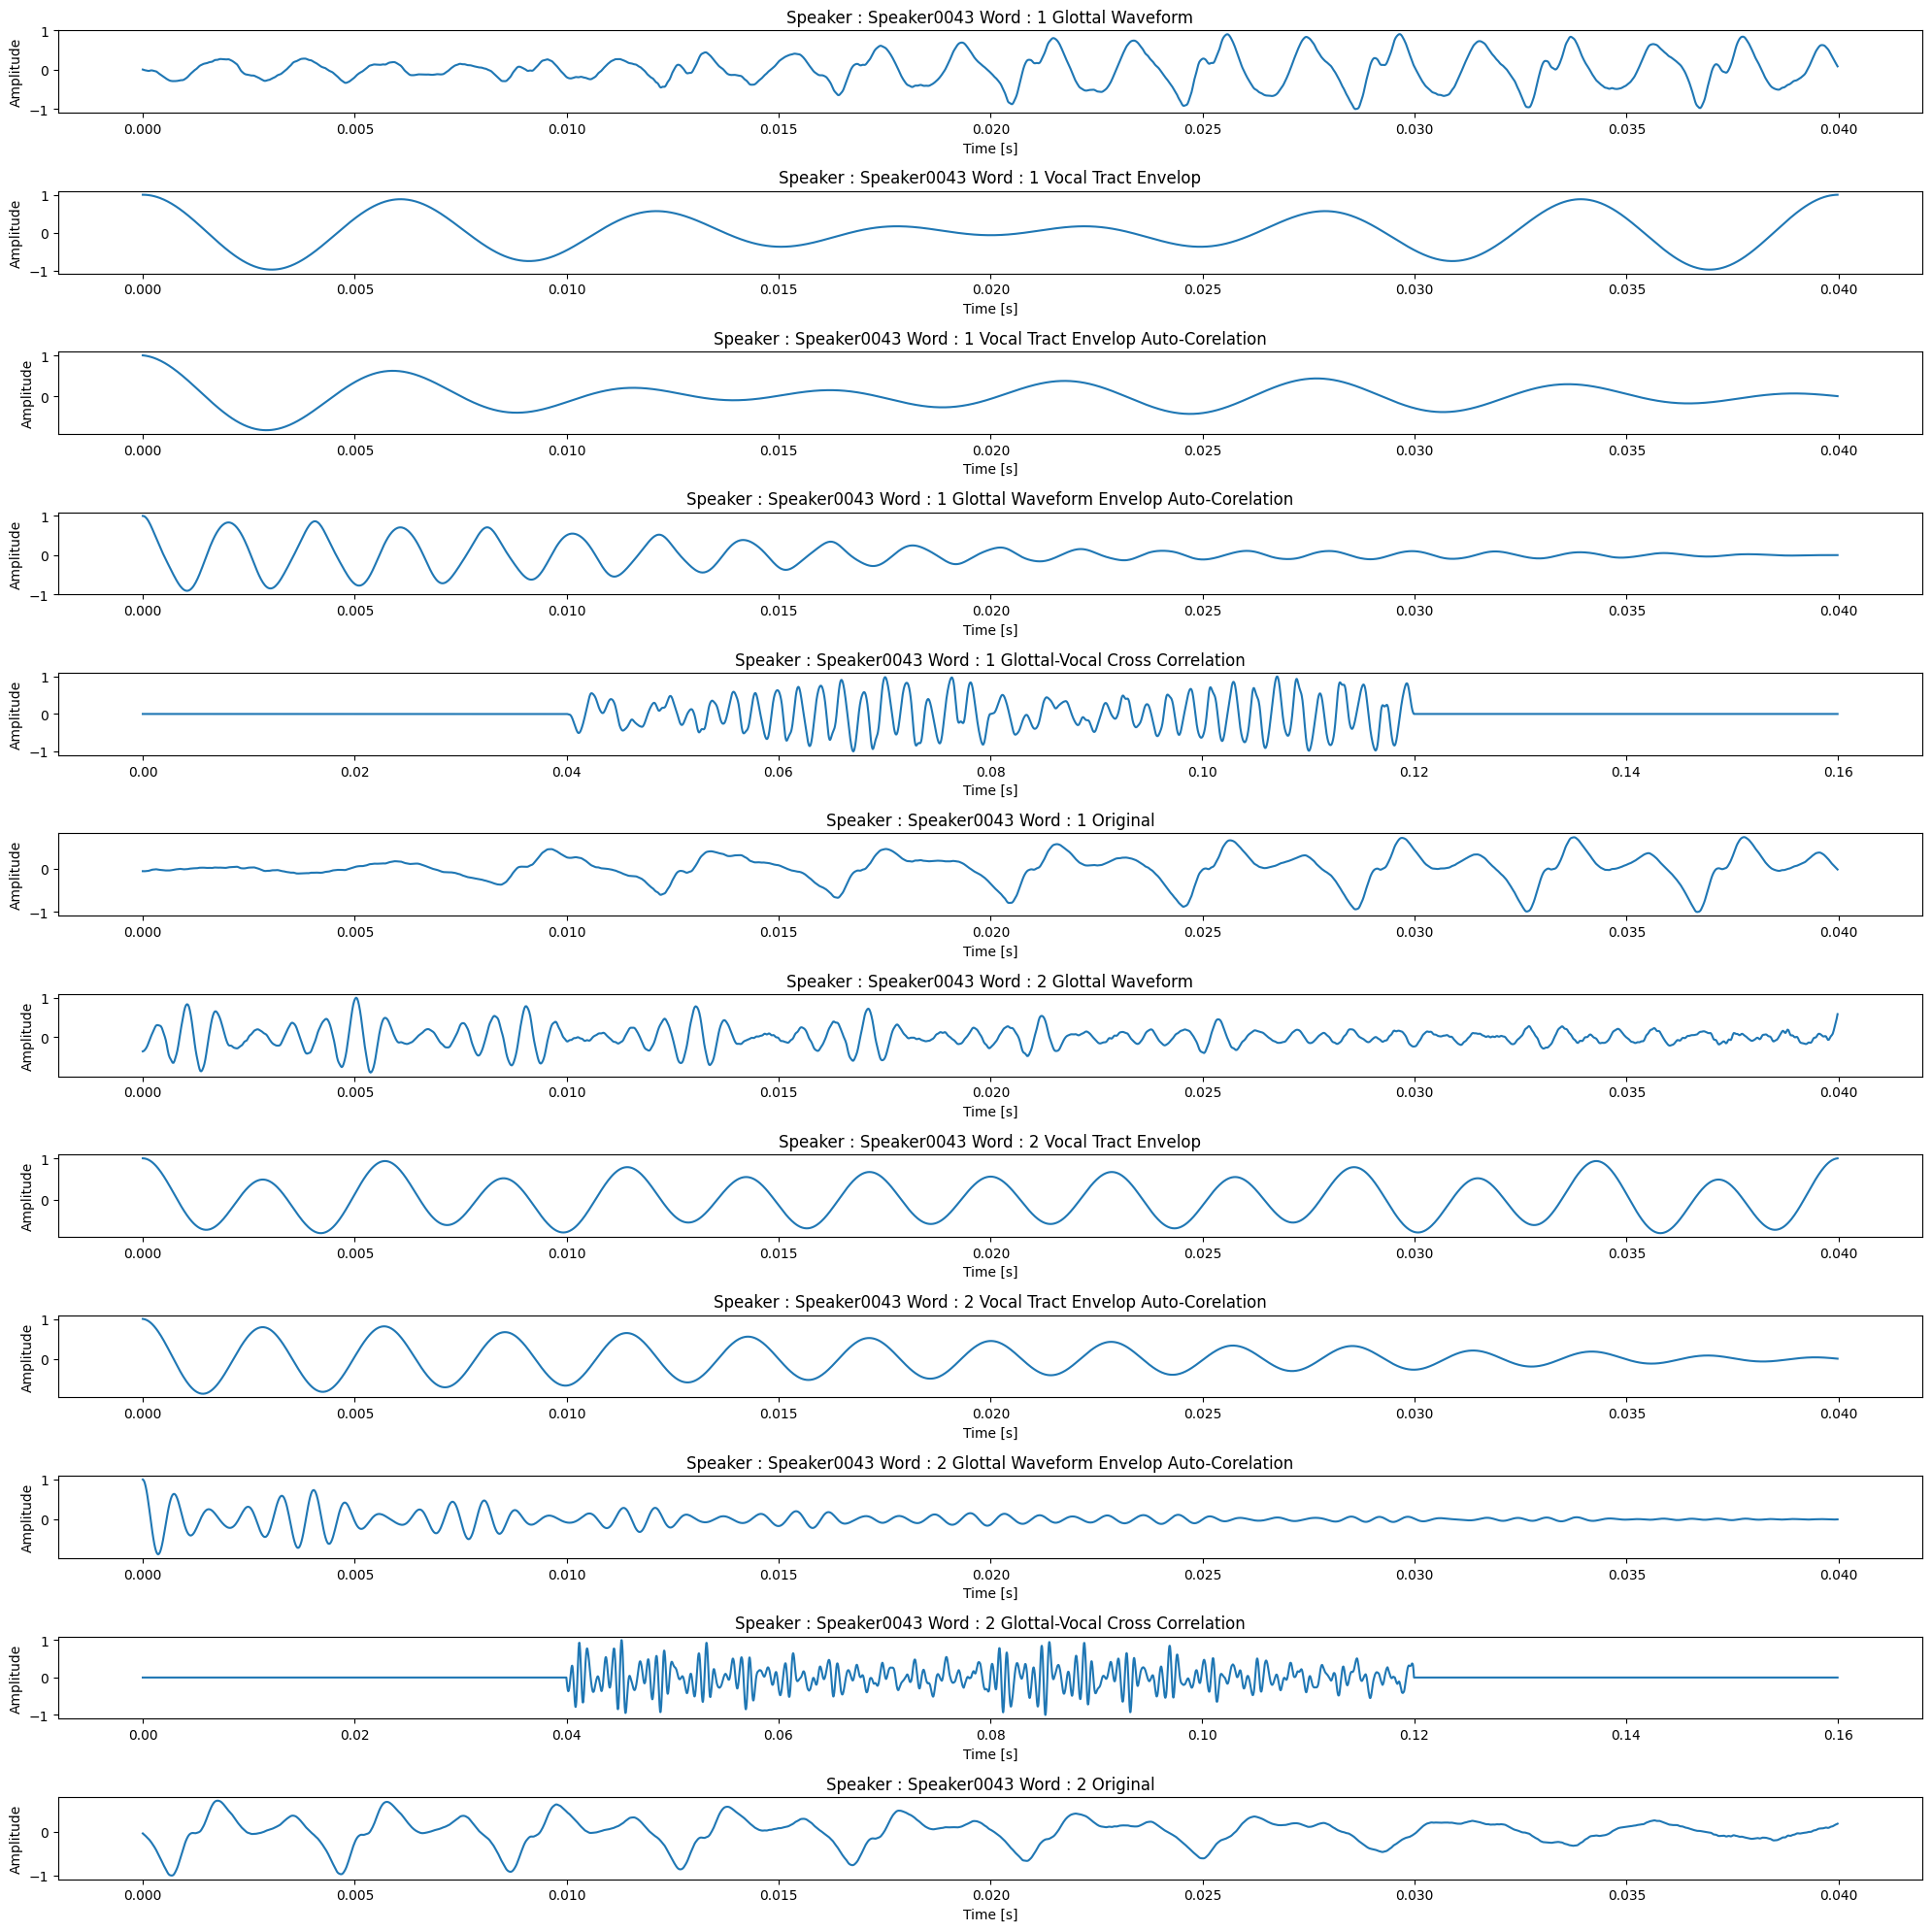

In [14]:
plot_glottal_impulse(data_folder,num_speakers,num_utterances,frame_length_msec)

Speaker number 1.



[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1600) too large for available bit count (1568)


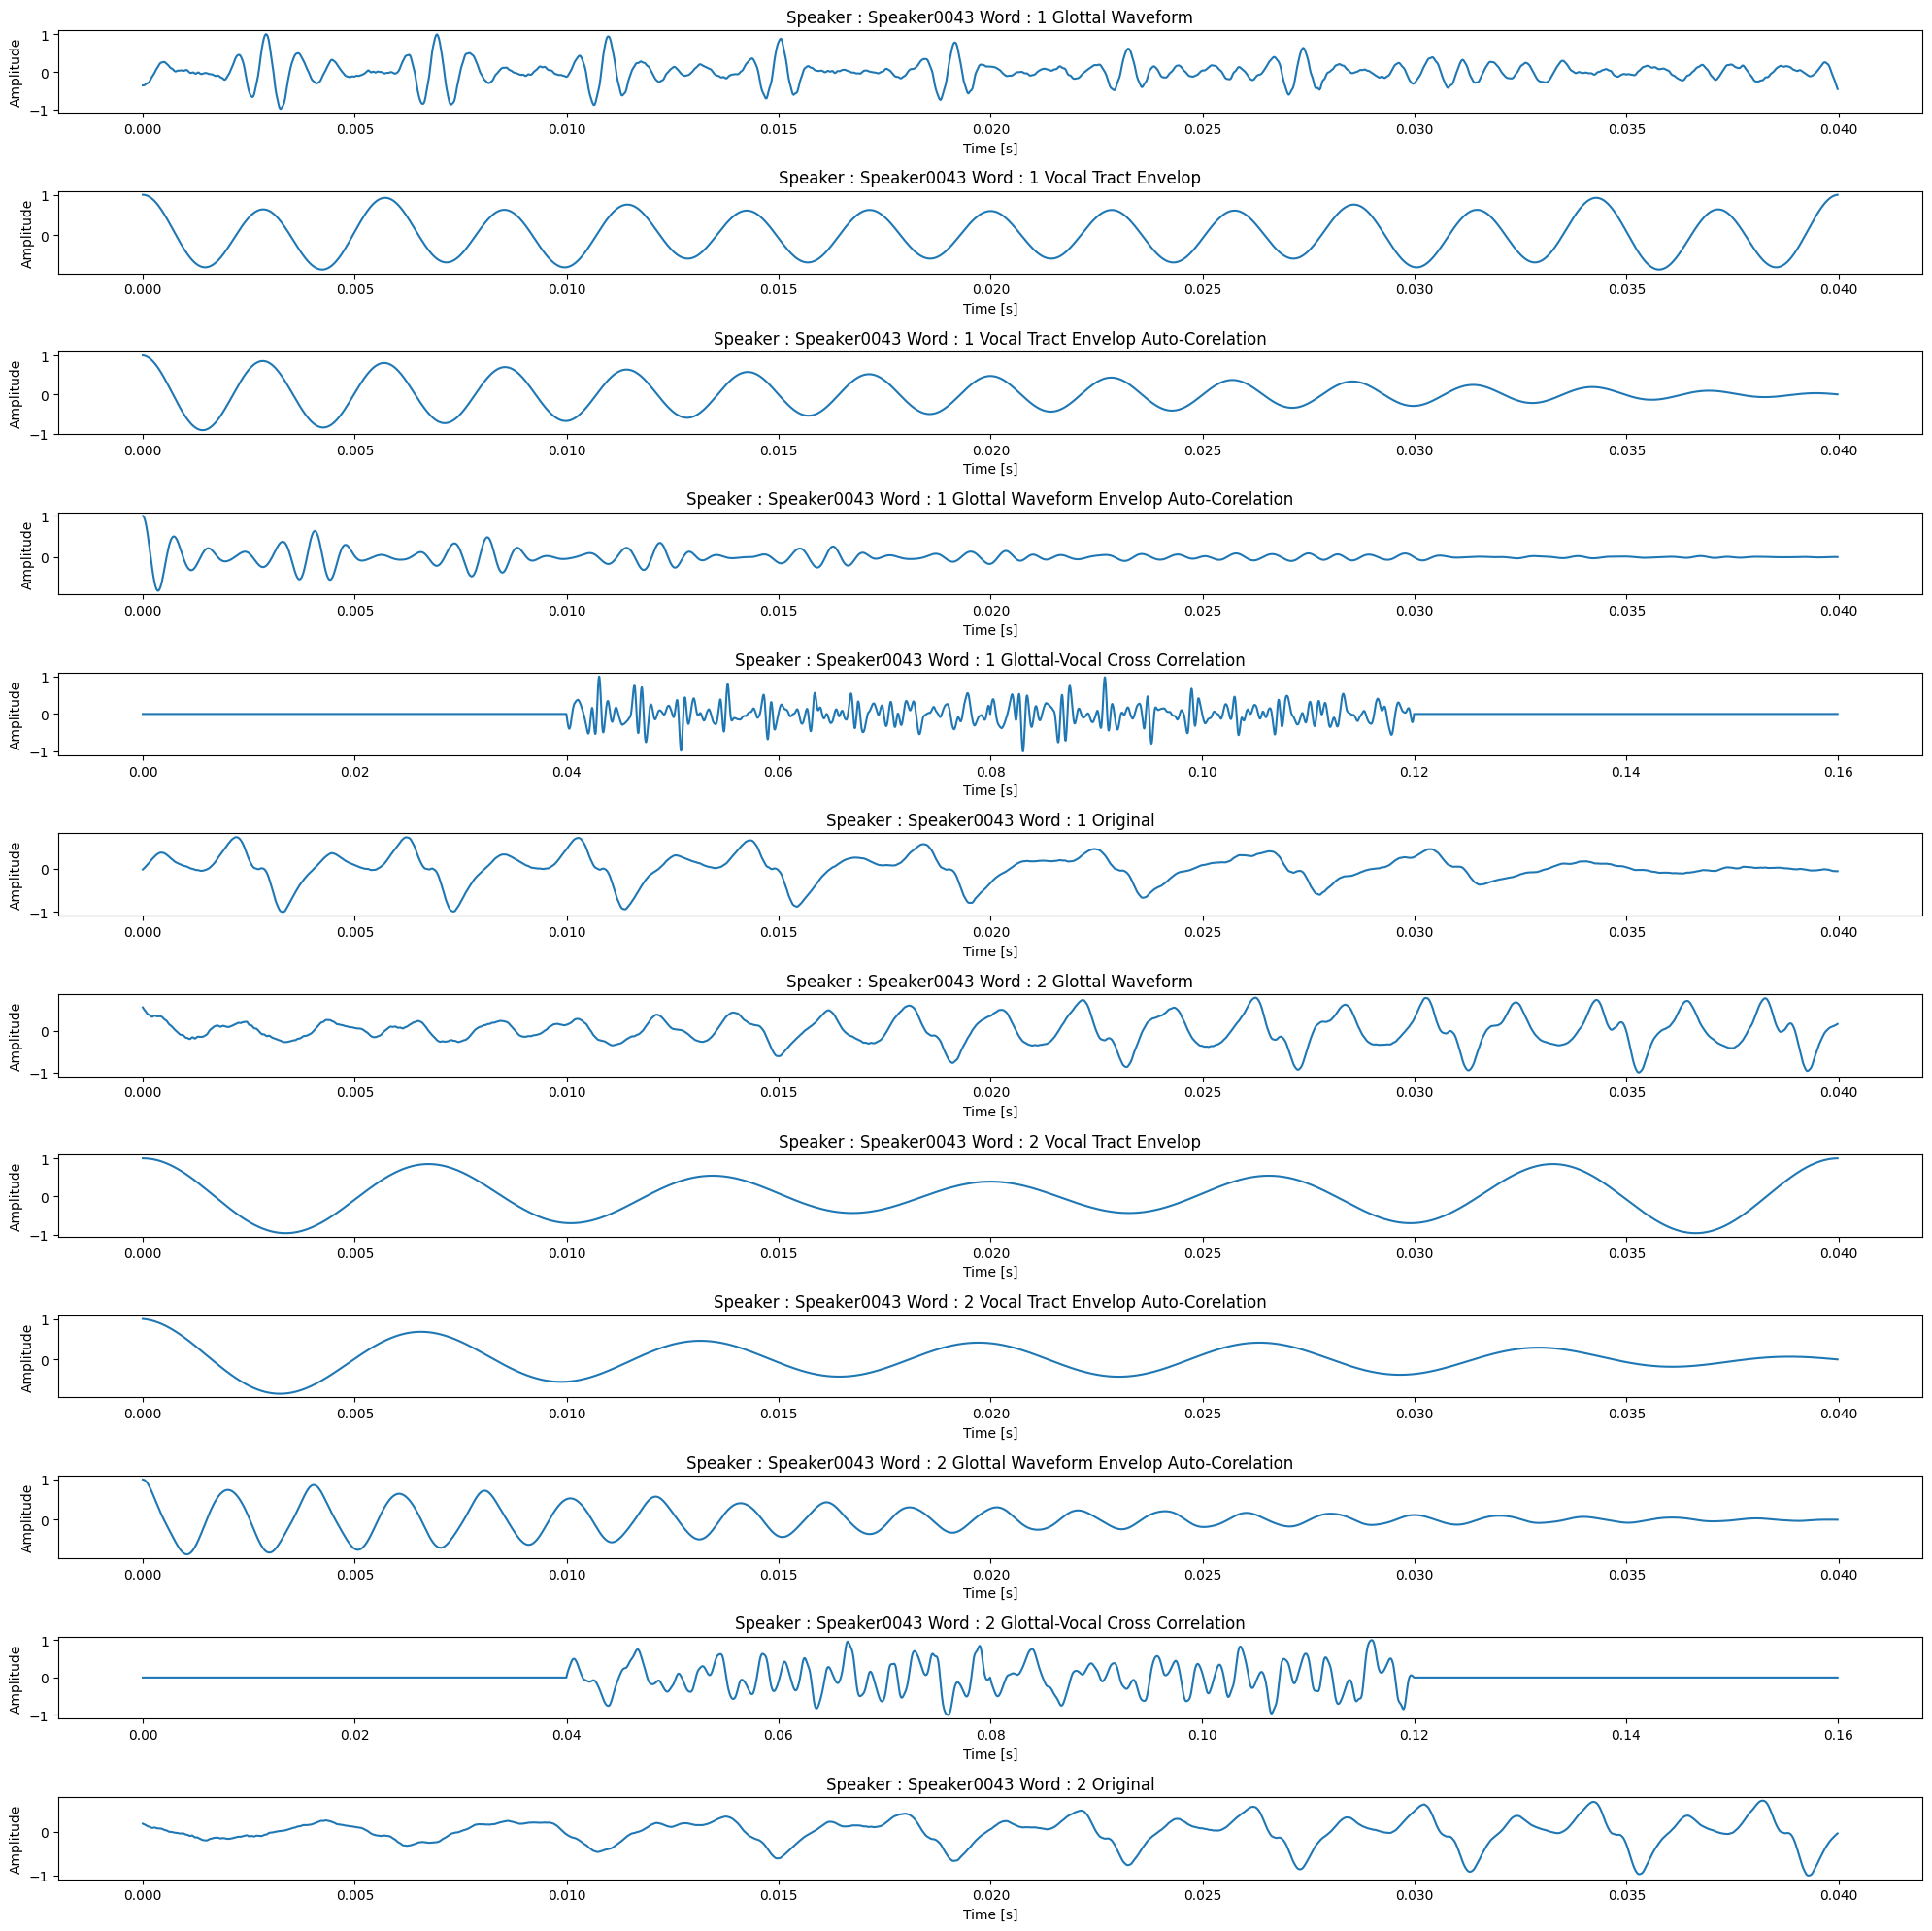

In [15]:
plot_glottal_impulse(data_folder,num_speakers,num_utterances,frame_length_msec,True)

# 2) SVD Analysis

In [16]:
import numpy as np
from scipy.linalg import hankel

def hankel_svd(speech_sample, hankel_cols=None):

    n = len(speech_sample)
    
    hankel_matrix = hankel(speech_sample, np.zeros(n))
    hankel_matrix = hankel_matrix[:n, :n]
    U, S, Vt = np.linalg.svd(hankel_matrix, full_matrices=False)

    return S

In [17]:
def svd(data_folder,num_speakers=5,num_utterances=1000,frame_length_msec=30,comp=25,sr=44100,verbose=True,iteration=1):
    glot=[]
    vt=[]
    
    total_speaker = 0
    for speaker in os.listdir(data_folder):
        curr_time=0
        req_time=num_utterances*frame_length_msec
        
        y=[]
        wav_files=os.listdir(os.path.join(data_folder, speaker))
        idx=0
        while curr_time<req_time:
            if wav_files[idx].endswith(".wav"):
                wav_file_path = os.path.join(data_folder, speaker, wav_files[idx])

                y_curr, sr = librosa.load(wav_file_path, sr=sr)
                
                non_silent_intervals = librosa.effects.split(y_curr, top_db=10)  # 20 dB threshold can be adjusted
                y_non_silent = []
                begin=0
                for start, end in non_silent_intervals:
                    if start-begin<(50*sr//1000):
                        y_non_silent.extend(y_curr[begin:start])
                        
                    y_non_silent.extend(y_curr[start:end])
                    begin=start
        
                y.extend(y_non_silent)
                
                curr_time=math.floor(len(y)*1000/sr)
#                 print(f'curr : {curr_time} req : {req_time}')
                idx+=1
                
        del wav_files
                
        frame_length_samples=frame_length_msec*sr//1000
        frames = librosa.util.frame(y, frame_length=frame_length_samples, hop_length=frame_length_samples).T
        frames=frames[:num_utterances]
        del y#,y_normalized

        for frame in frames:
            v,g=mfcc_to_vocal_tract_envelope_time_domain(frame,comp)
            vt.append(hankel_svd(v))
            glot.append(hankel_svd(g))

        del frames
                        
        total_speaker += 1
        if total_speaker != 0 and total_speaker % 1 == 0 and verbose:
            print(f"{total_speaker} speakers completed.\n")

        if total_speaker == num_speakers:
            break
            
    glot=np.mean(glot,axis=0)
    vt=np.mean(vt,axis=0)
    
        
    fig, ax = plt.subplots(2, 1, figsize=(20, 20))
    num_comp = np.arange(1, comp+1, 1)
    
    ax[0].plot(num_comp, glot[:comp],'o-', linewidth=2, markersize=6, color='blue')
    ax[0].set_xlabel('Components')
    ax[0].set_ylabel('Singular Value')
    ax[0].set_title('Glottal')
    
    ax[1].plot(num_comp, vt[:comp],'o-', linewidth=2, markersize=6, color='blue')
    ax[1].set_xlabel('Components')
    ax[1].set_ylabel('Singular Value')
    ax[1].set_title('Vocal Tract')
            
    
    del vt,glot

In [18]:
num_speakers=5
num_utterances=10
frame_length_msec=40
comp=25
data_folder="/kaggle/input/speaker-recognition-audio-dataset/50_speakers_audio_data"

[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1600) too large for available bit count (1568)


1 speakers completed.

2 speakers completed.

3 speakers completed.

4 speakers completed.

5 speakers completed.



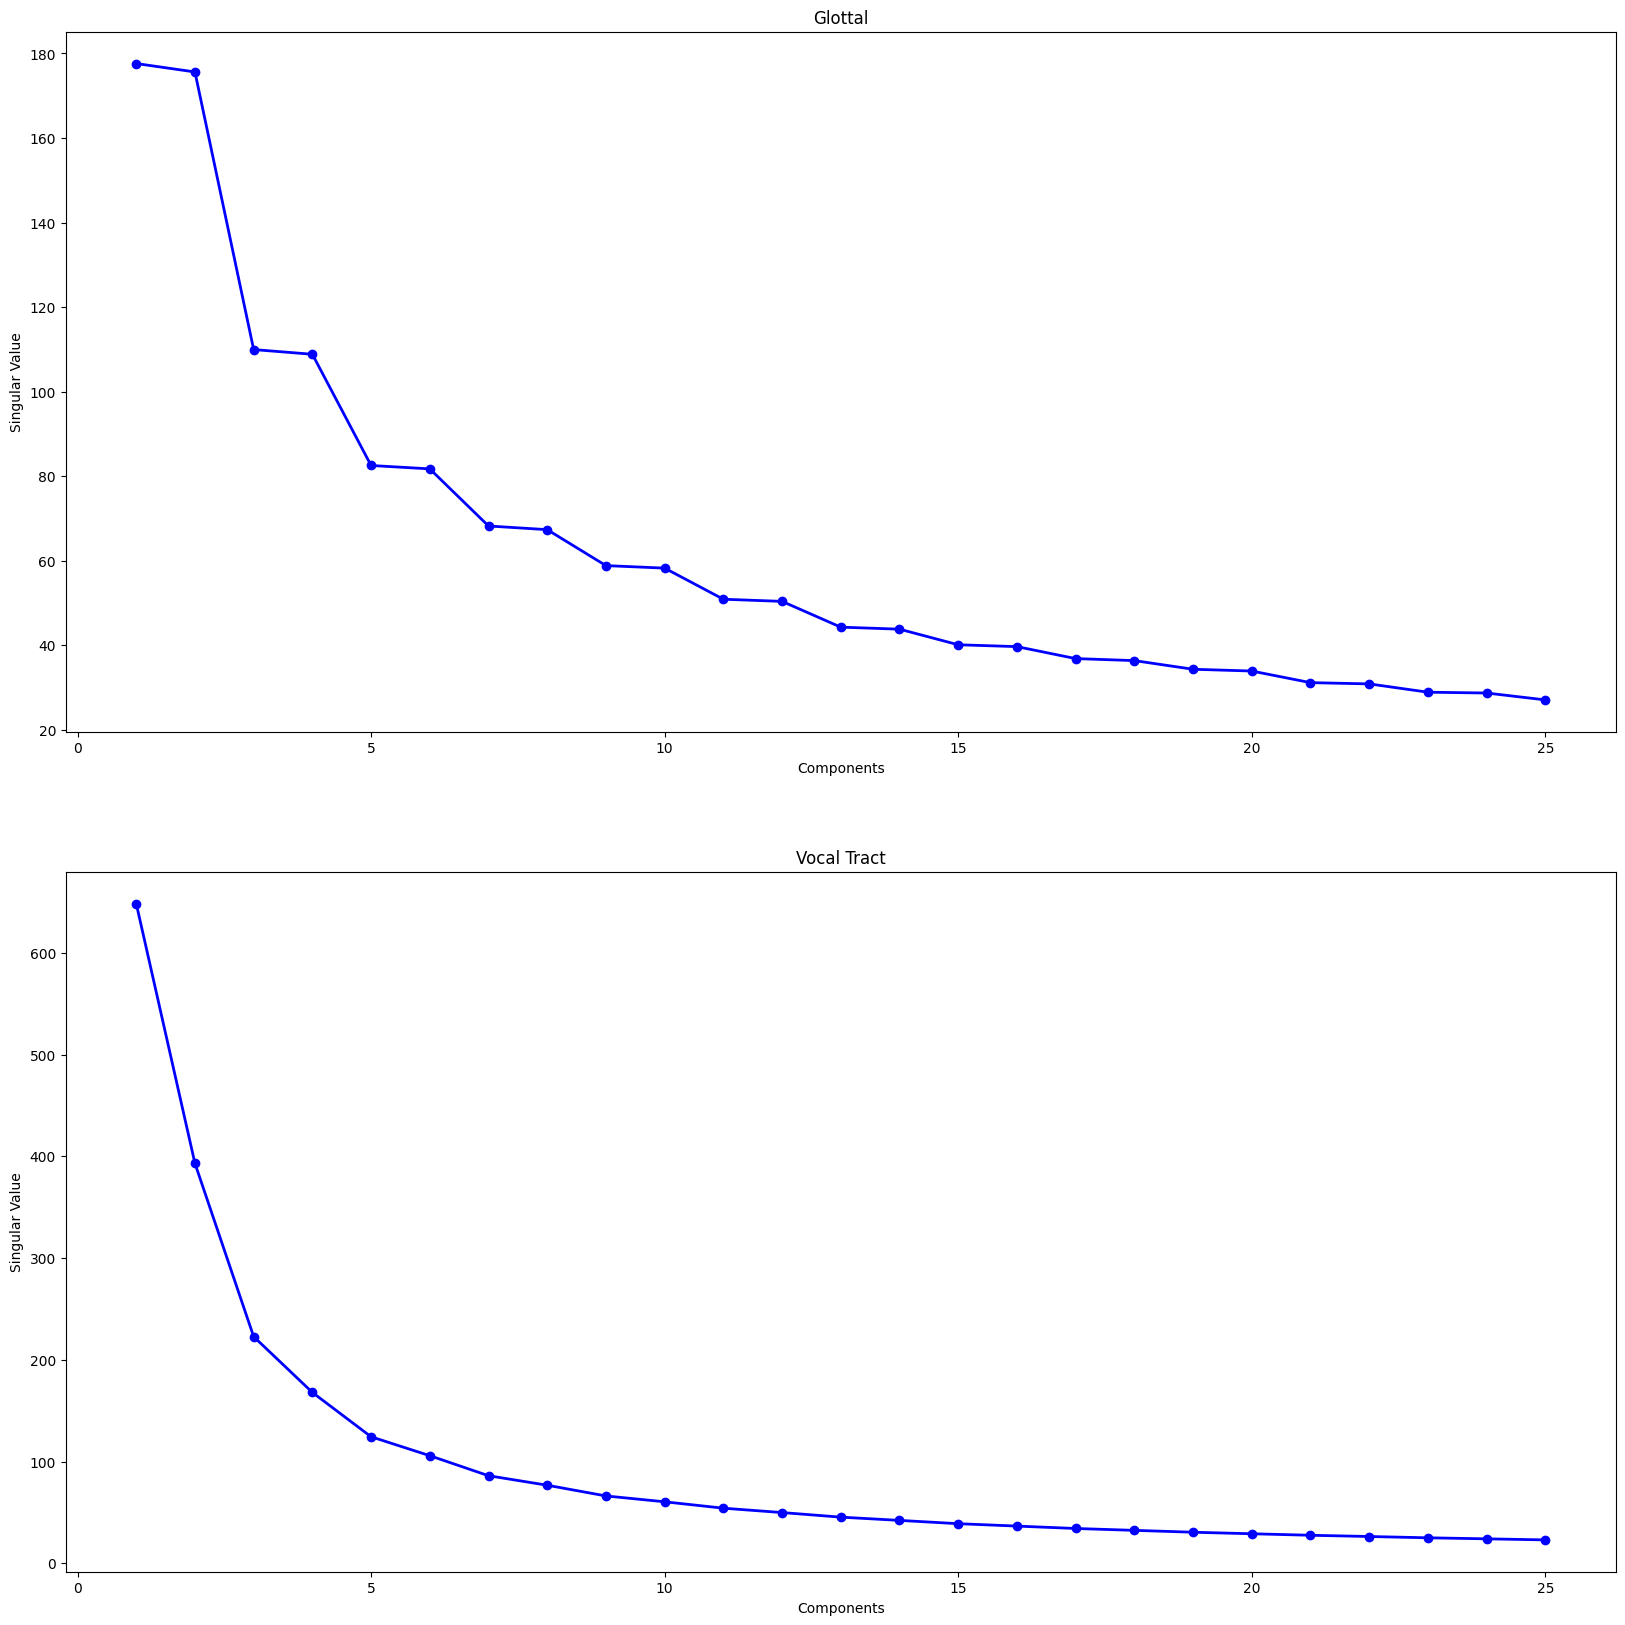

In [19]:
svd(data_folder,num_speakers,num_utterances,frame_length_msec,comp)

# 3) Encoding Deviation Analysis

In [20]:
def encode_audio_signal(signal, sr=44100, n_fft=1024, n_mels=39, hop_length=512):
    # Adjust n_fft based on signal length
    signal_length = len(signal)
    if signal_length < n_fft:
        n_fft = signal_length
    
    # Compute the Mel-spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=signal, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    
    # Convert to log scale (dB)
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    
    # Flatten the Mel-spectrogram to create a fixed-length vector
    feature_vector = log_mel_spectrogram.flatten()
    
    # Normalize the feature vector
    feature_vector = feature_vector / np.linalg.norm(feature_vector)
    
    return feature_vector

In [21]:
def deviation(data_folder,num_speakers=5,num_frames=1000,frame_length_msec=30,sr=44100,verbose=True,iteration=1):
    x_glot=[]
    x_vt=[]
    
    total_speaker = 0
    for speaker in os.listdir(data_folder):
        curr_time=0
        req_time=num_frames*frame_length_msec
        
        y=[]
        wav_files=os.listdir(os.path.join(data_folder, speaker))
        idx=0
        while curr_time<req_time:
            if wav_files[idx].endswith(".wav"):
                wav_file_path = os.path.join(data_folder, speaker, wav_files[idx])

                y_curr, sr = librosa.load(wav_file_path, sr=sr)
                
                non_silent_intervals = librosa.effects.split(y_curr, top_db=10)  # 20 dB threshold can be adjusted
                y_non_silent = []
                begin=0
                for start, end in non_silent_intervals:
                    if start-begin<(50*sr//1000):
                        y_non_silent.extend(y_curr[begin:start])
                        
                    y_non_silent.extend(y_curr[start:end])
                    begin=start
        
                y.extend(y_non_silent)
                
                curr_time=math.floor(len(y)*1000/sr)
#                 print(f'curr : {curr_time} req : {req_time}')
                idx+=1
                
        del wav_files
                
        frame_length_samples=frame_length_msec*sr//1000
        frames = librosa.util.frame(y, frame_length=frame_length_samples, hop_length=frame_length_samples).T
        frames=frames[:num_frames]
        del y#,y_normalized

        curr_vt=[]
        curr_glot=[]
        for frame in frames:
            vt,glot=mfcc_to_vocal_tract_envelope_time_domain(frame,iteration)
            curr_vt.append(encode_audio_signal(vt))
            curr_glot.append(encode_audio_signal(glot))

            del vt,glot

        x_vt.append(curr_vt)
        x_glot.append(curr_glot)
        del frames,curr_glot,curr_vt
                        
        total_speaker += 1
        if total_speaker != 0 and total_speaker % 1 == 0 and verbose:
            print(f"{total_speaker} speakers completed.\n")

        if total_speaker == num_speakers:
            break
    
    return x_vt,x_glot

In [22]:
def rmse(A,B,epsilon=1e-10):
    avg=0
    size=len(A)
    
    for i in range(size):
        avg+=((A[i]-B[i])**2)
        
    return math.sqrt(avg)

In [23]:
def calculate_similarity(speaker1,speaker2):
    num_utterances=len(speaker1)
#     arr_size=len(speaker1[0])
#     print(speaker1)
    
    avg=0
    for arr1 in speaker1:
        for arr2 in speaker2:
#             print(arr1)
            avg+=rmse(arr1,arr2)
            
    avg/=(num_utterances**2)
    
    return avg

In [24]:
def get_corr(data_folder,num_speakers=5,num_frames=1000,start_frame_size=10,end_frame_size=100,hop_size=10,iteration=1):
    corr_vt=[]
    corr_glot=[]

    while start_frame_size<=end_frame_size:
        vt,glot=deviation(data_folder,num_speakers,num_frames,start_frame_size,44100,False,iteration)
        curr_corr_vt=[[calculate_similarity(list(x),list(y)) for x in vt] for y in vt]
        curr_corr_glot=[[calculate_similarity(list(x),list(y)) for x in glot] for y in glot]
        corr_vt.append(curr_corr_vt)
        corr_glot.append(curr_corr_glot)
        print(f'{start_frame_size} completed.')
        start_frame_size+=hop_size
        
    return corr_vt,corr_glot

In [25]:
num_speakers=5
start_frame_size=2
end_frame_size=10
hop_size=1
num_frames=100
iteration=1
data_folder="/kaggle/input/speaker-recognition-audio-dataset/50_speakers_audio_data"

In [26]:
corr_vt,corr_glot=get_corr(data_folder,num_speakers,num_frames,start_frame_size,end_frame_size,hop_size,iteration)

[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1600) too large for available bit count (1568)
/opt/conda/lib/python3.10/site-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


2 completed.


[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1600) too large for available bit count (1568)


3 completed.


[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1600) too large for available bit count (1568)


4 completed.


[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1600) too large for available bit count (1568)


5 completed.


[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1600) too large for available bit count (1568)


6 completed.


[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1600) too large for available bit count (1568)


7 completed.


[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1600) too large for available bit count (1568)


8 completed.


[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1600) too large for available bit count (1568)


9 completed.


[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1600) too large for available bit count (1568)


10 completed.


In [27]:
import seaborn as sns

def plot_heatmap(corr):
    n = len(corr)
    num_cols = 2
    num_rows = (n + num_cols - 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

    # Flatten the axes array for easy iteration
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        if i < n:
            sns.heatmap(corr[i], ax=ax, annot=True, fmt=".2f", cmap='coolwarm')
            ax.set_title(f'Correlation Matrix {i + 1}')
        else:
            fig.delaxes(ax)  # Remove empty subplots

    plt.tight_layout()
    plt.show()

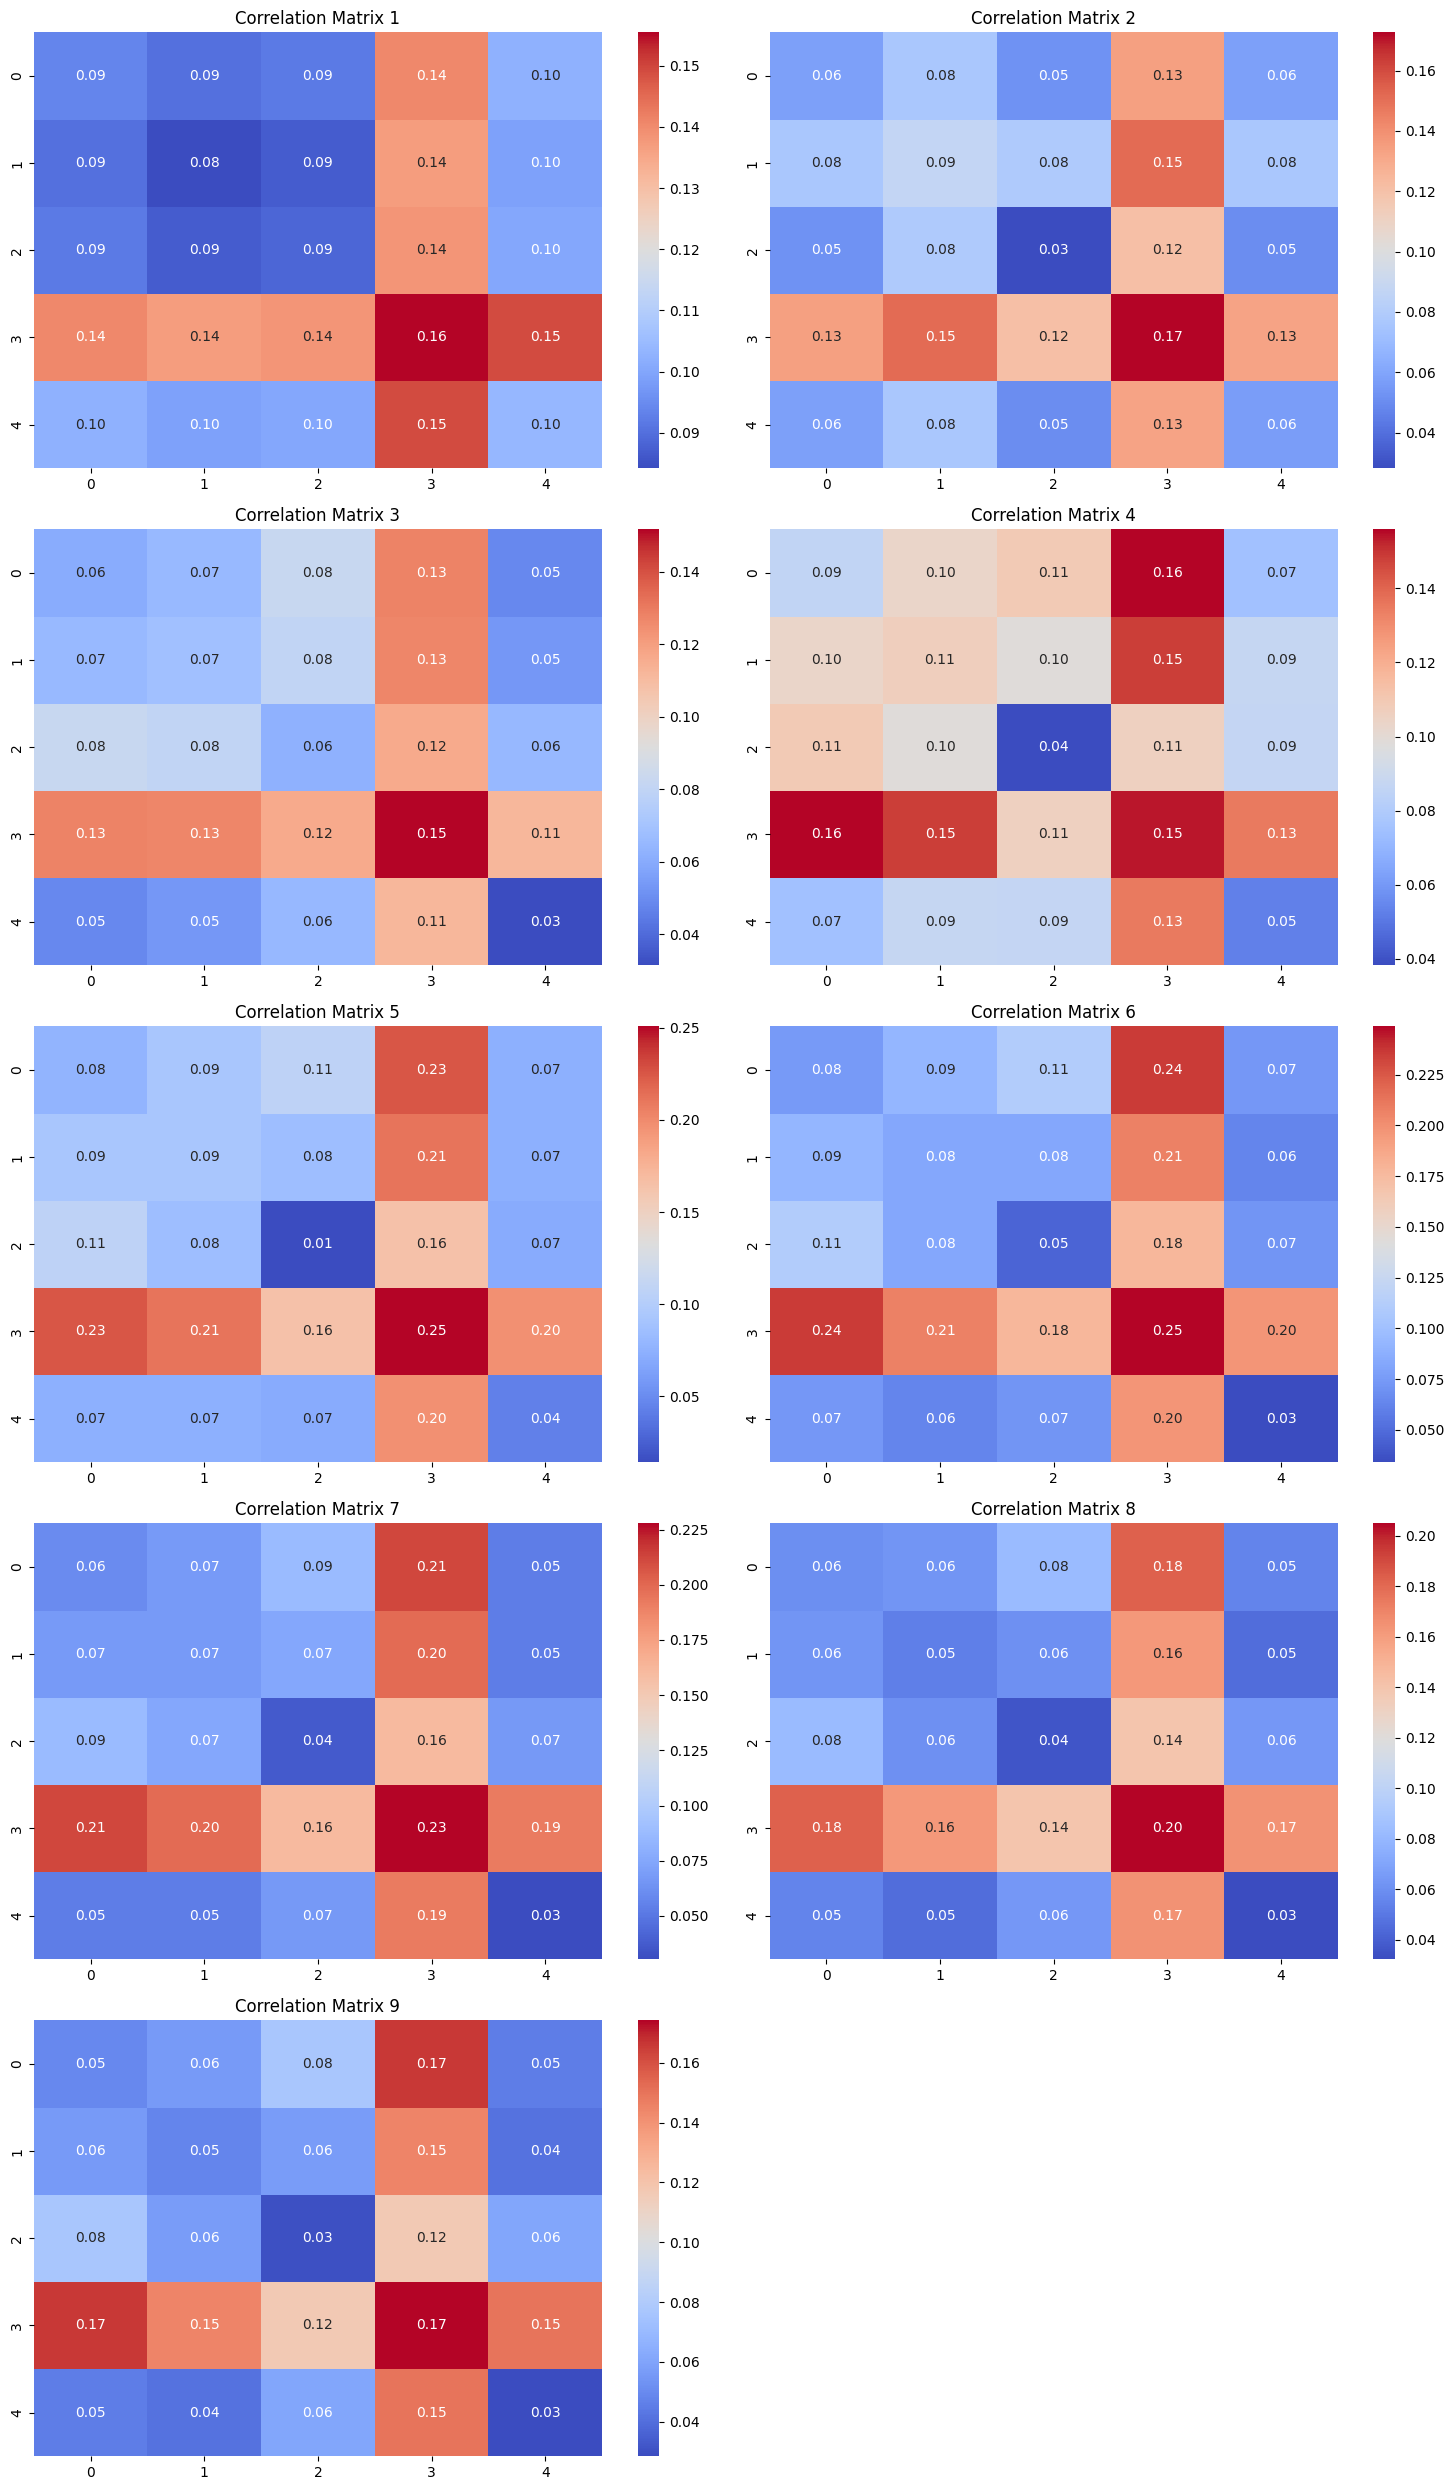

In [28]:
plot_heatmap(corr_vt)

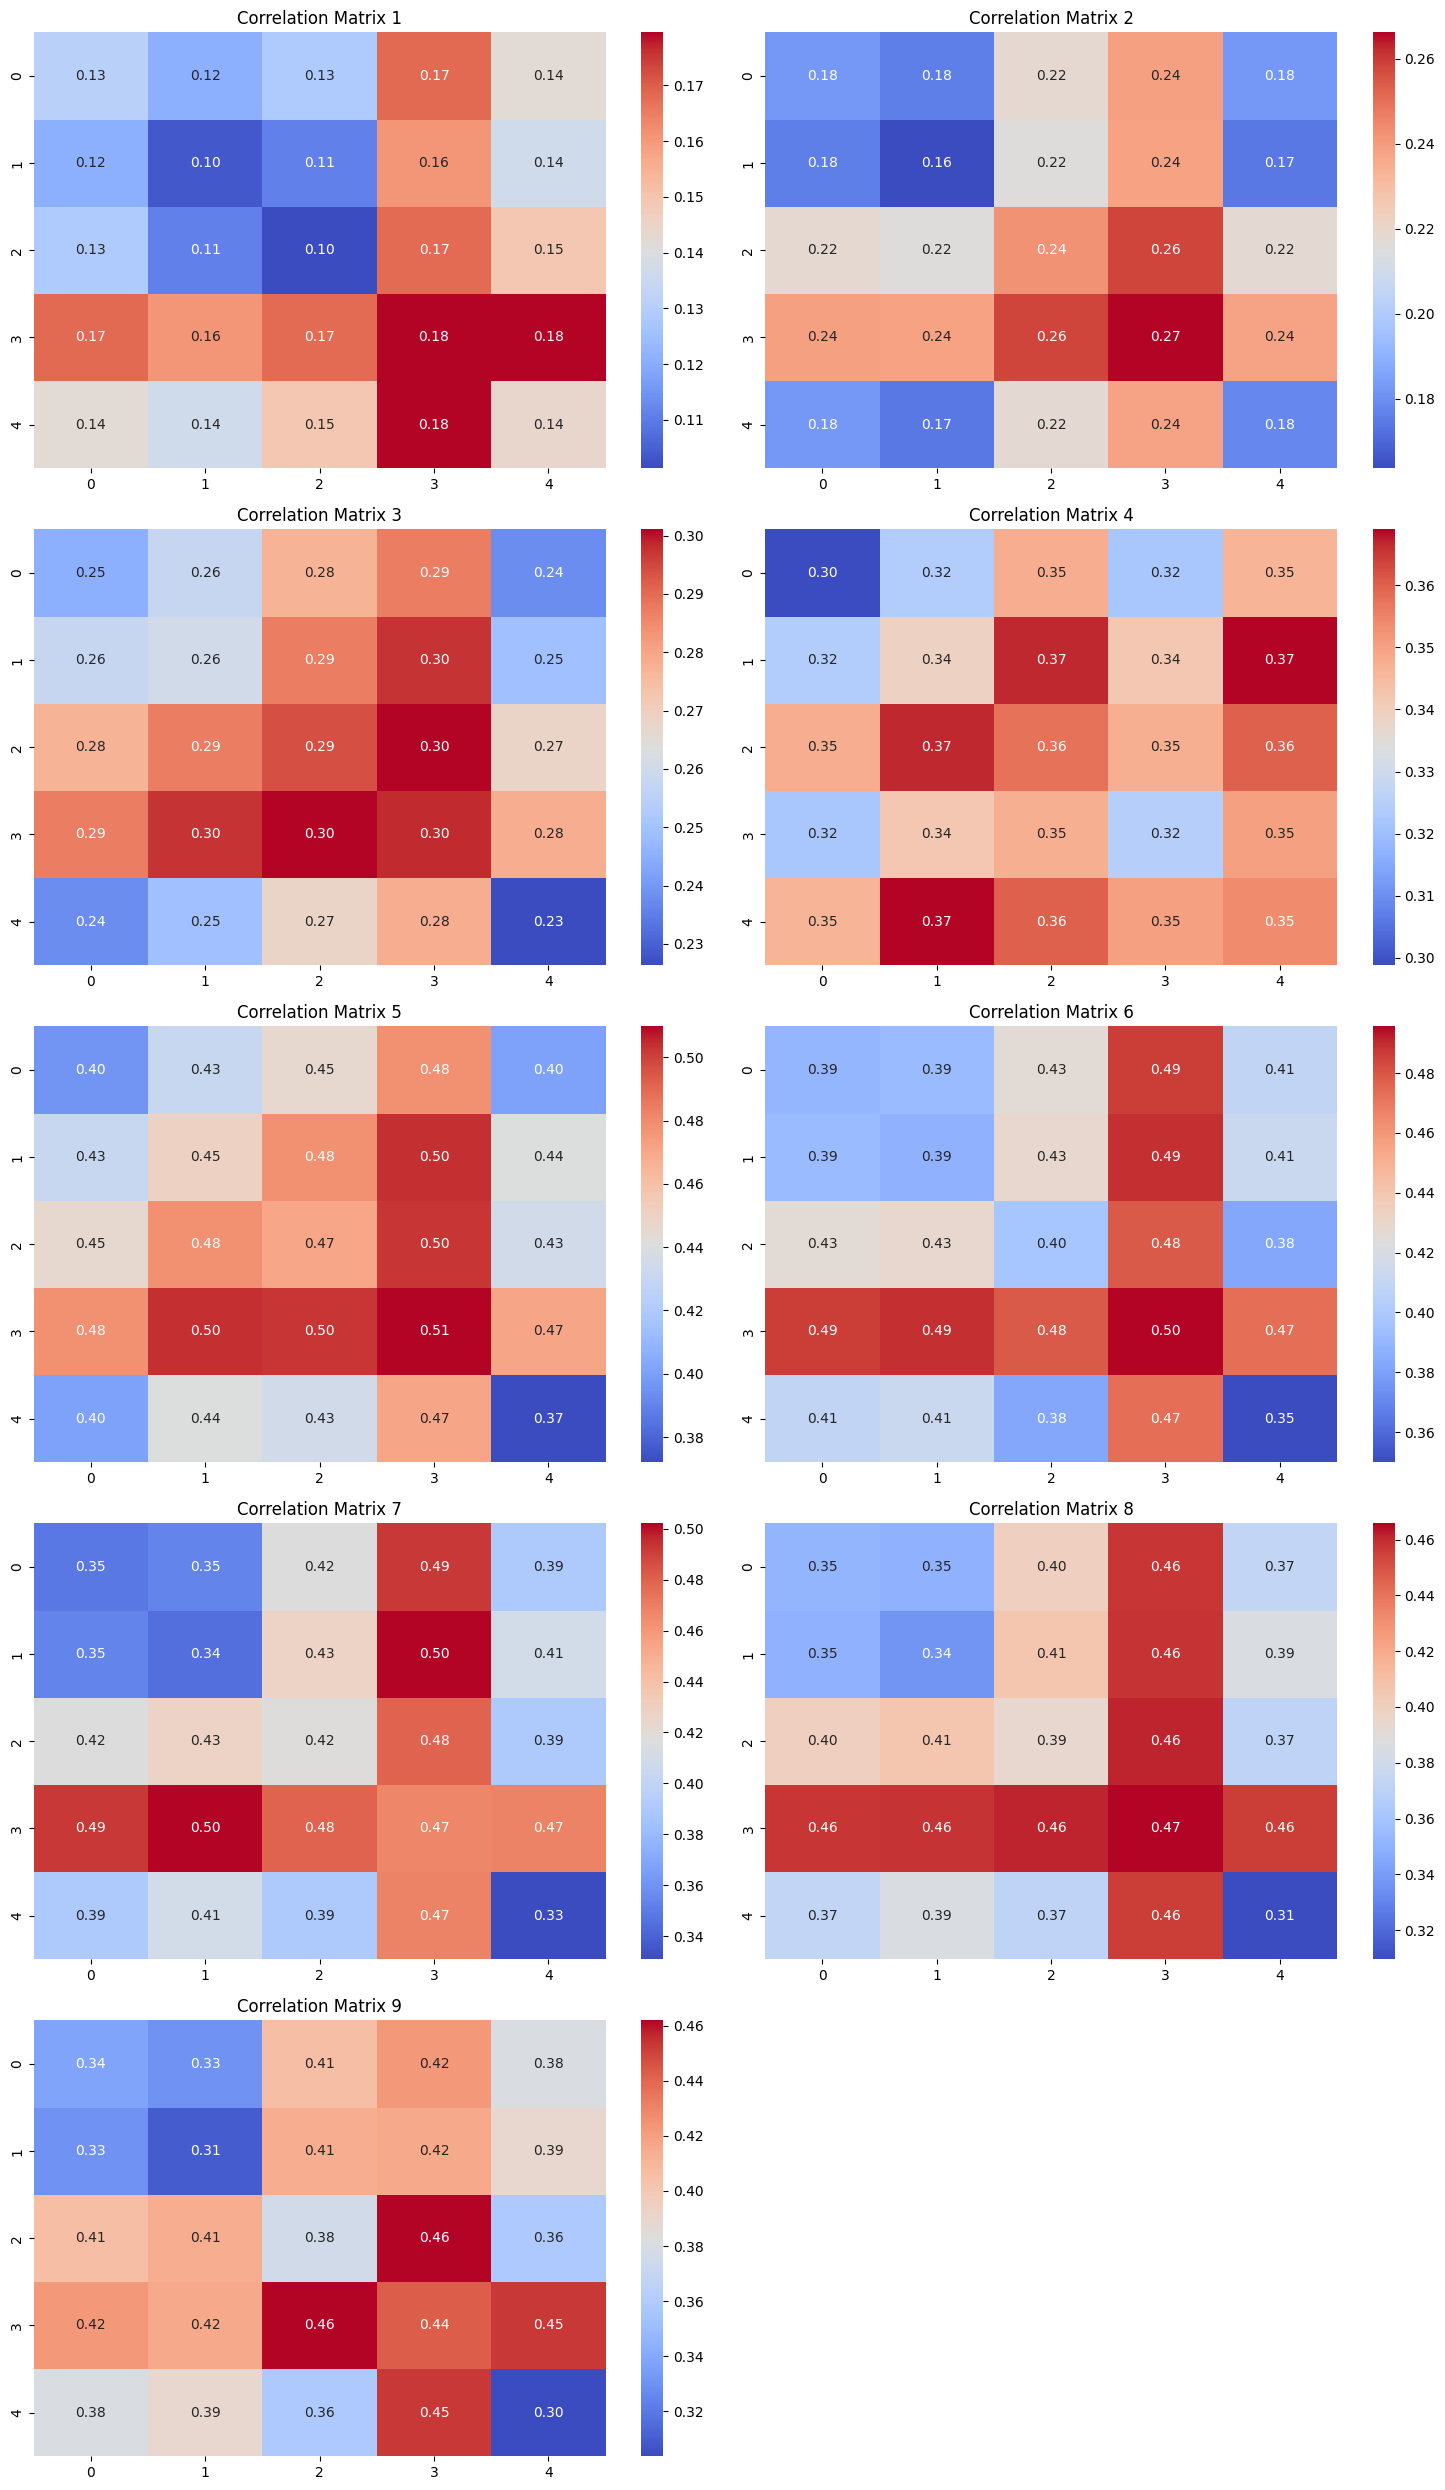

In [29]:
plot_heatmap(corr_glot)

In [30]:
num_speakers=5
start_frame_size=10
end_frame_size=100
hop_size=10
num_frames=100
iteration=1
data_folder="/kaggle/input/speaker-recognition-audio-dataset/50_speakers_audio_data"

In [31]:
corr_vt,corr_glot=get_corr(data_folder,num_speakers,num_frames,start_frame_size,end_frame_size,hop_size,iteration)

[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1600) too large for available bit count (1568)


10 completed.


[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1600) too large for available bit count (1568)


20 completed.


[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1600) too large for available bit count (1568)


30 completed.


[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1600) too large for available bit count (1568)


40 completed.


[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1600) too large for available bit count (1568)


50 completed.


[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1600) too large for available bit count (1568)


60 completed.


[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1600) too large for available bit count (1568)


70 completed.


[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1600) too large for available bit count (1568)


80 completed.


[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1600) too large for available bit count (1568)


90 completed.


[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1600) too large for available bit count (1568)


100 completed.


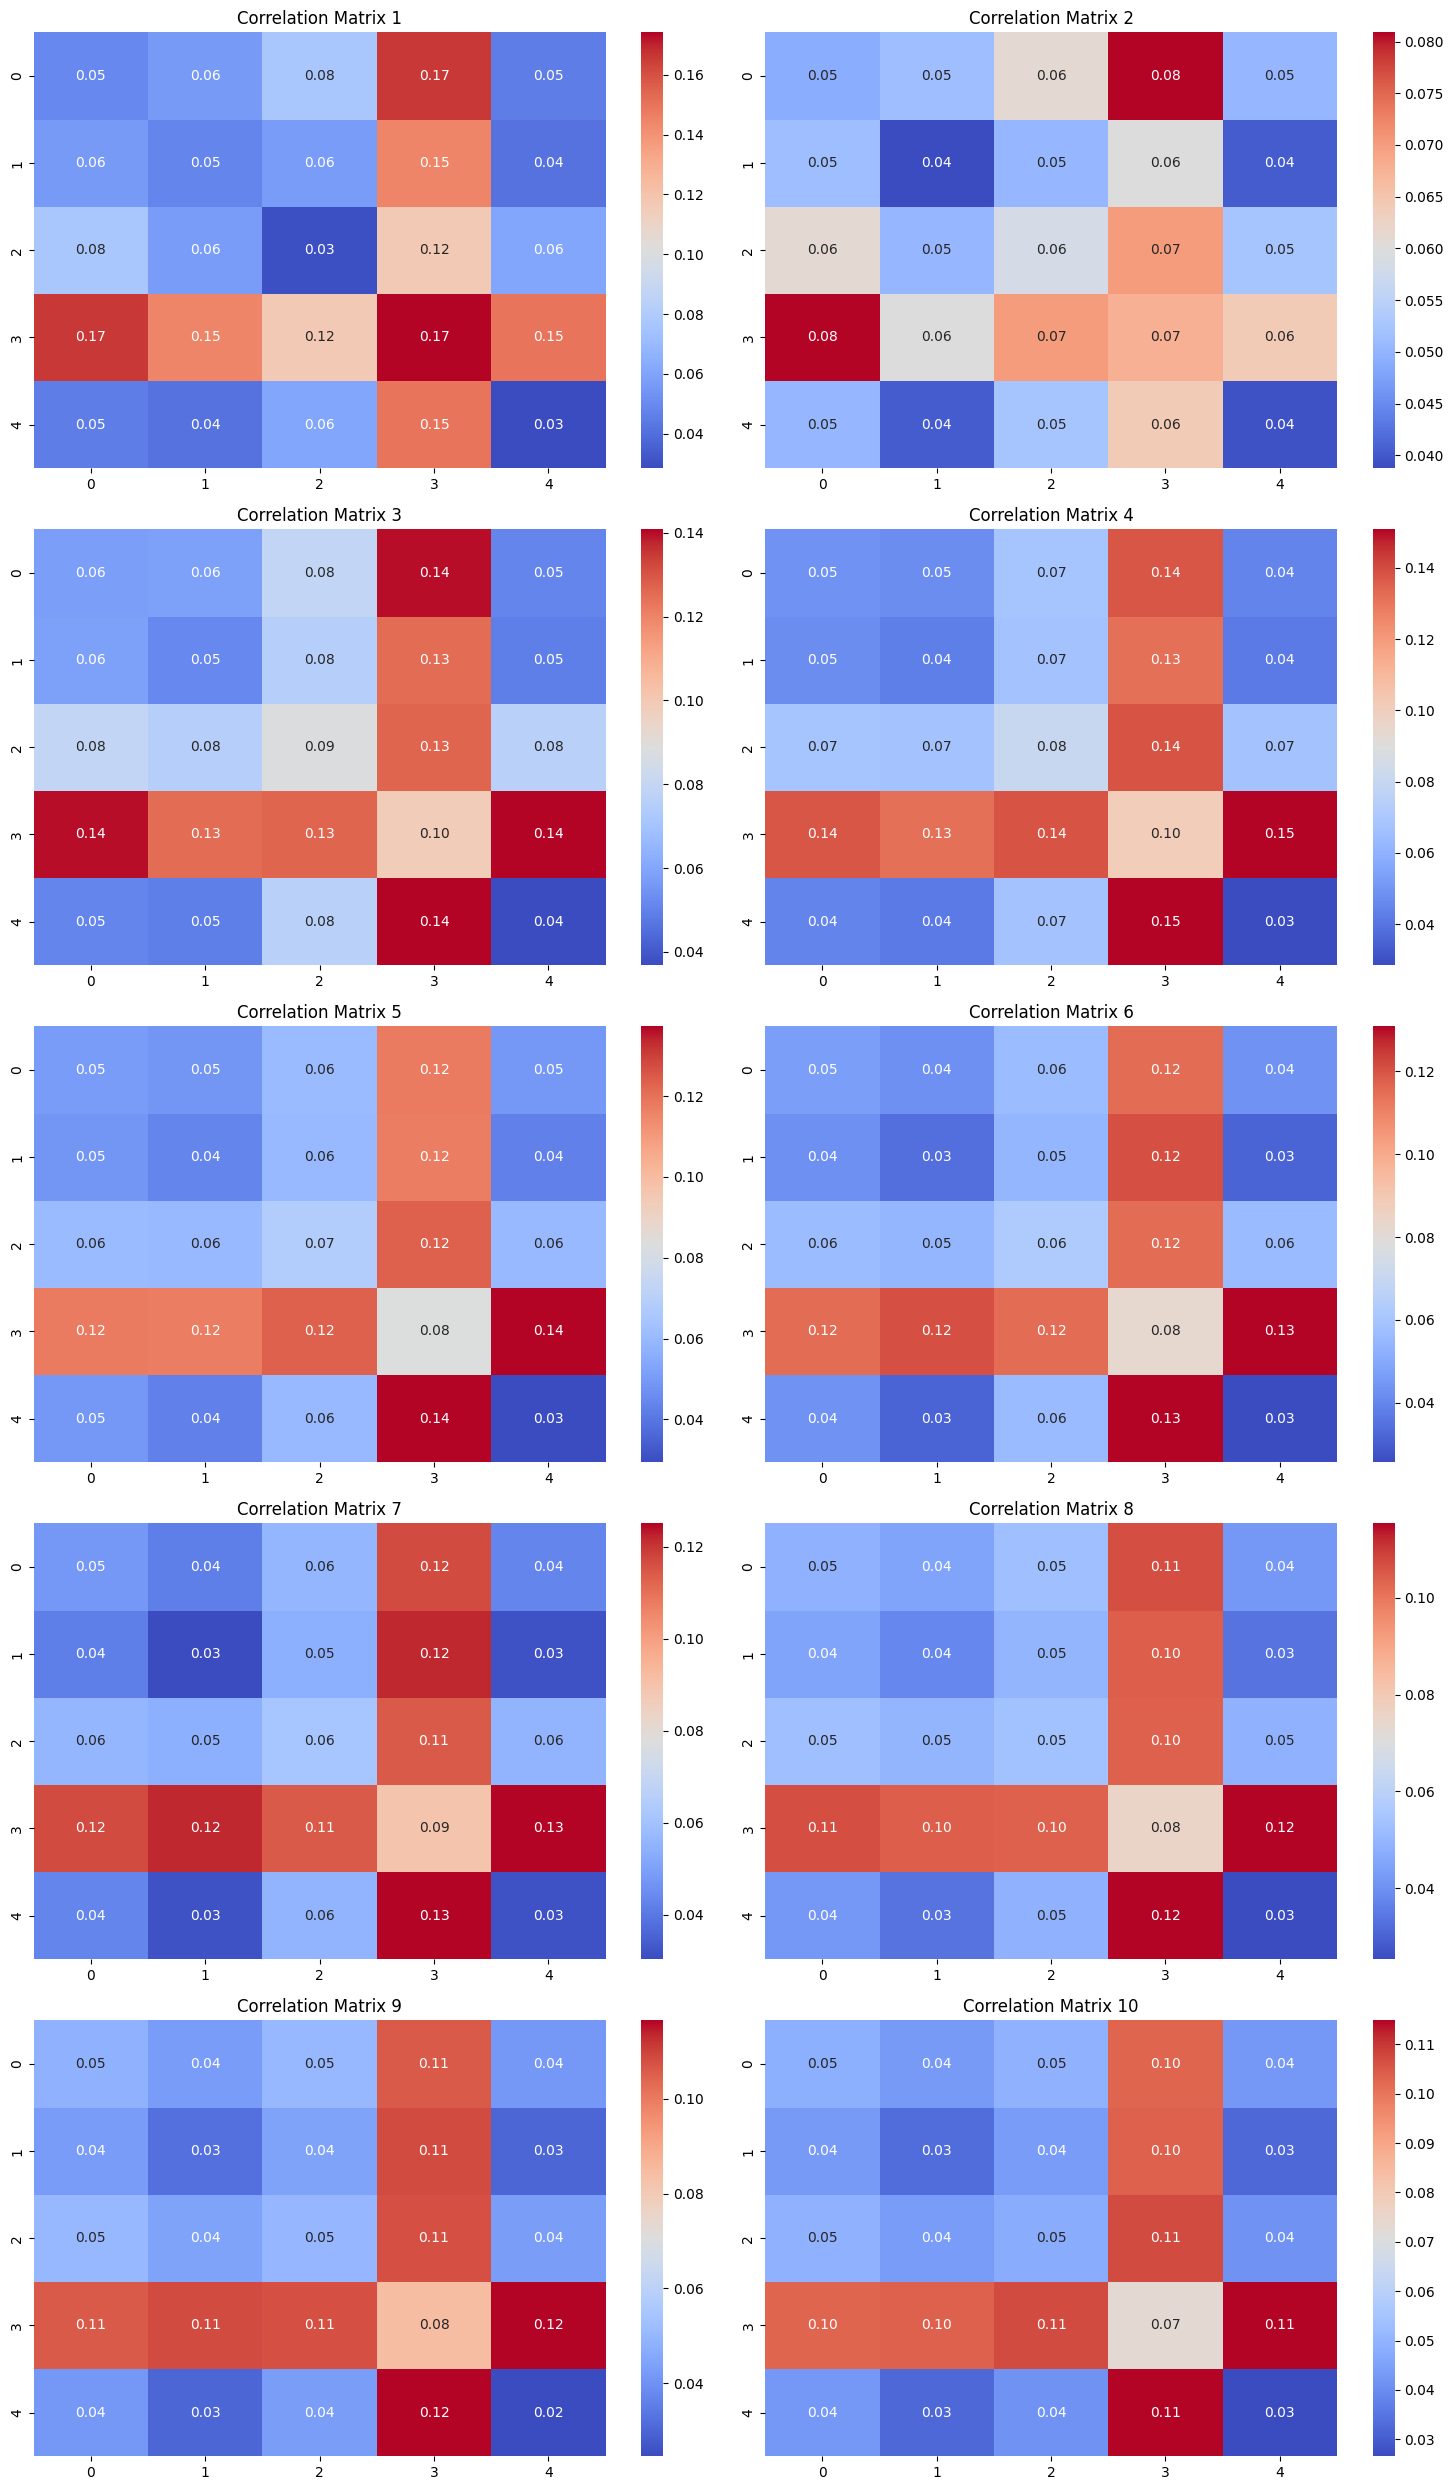

In [32]:
plot_heatmap(corr_vt)

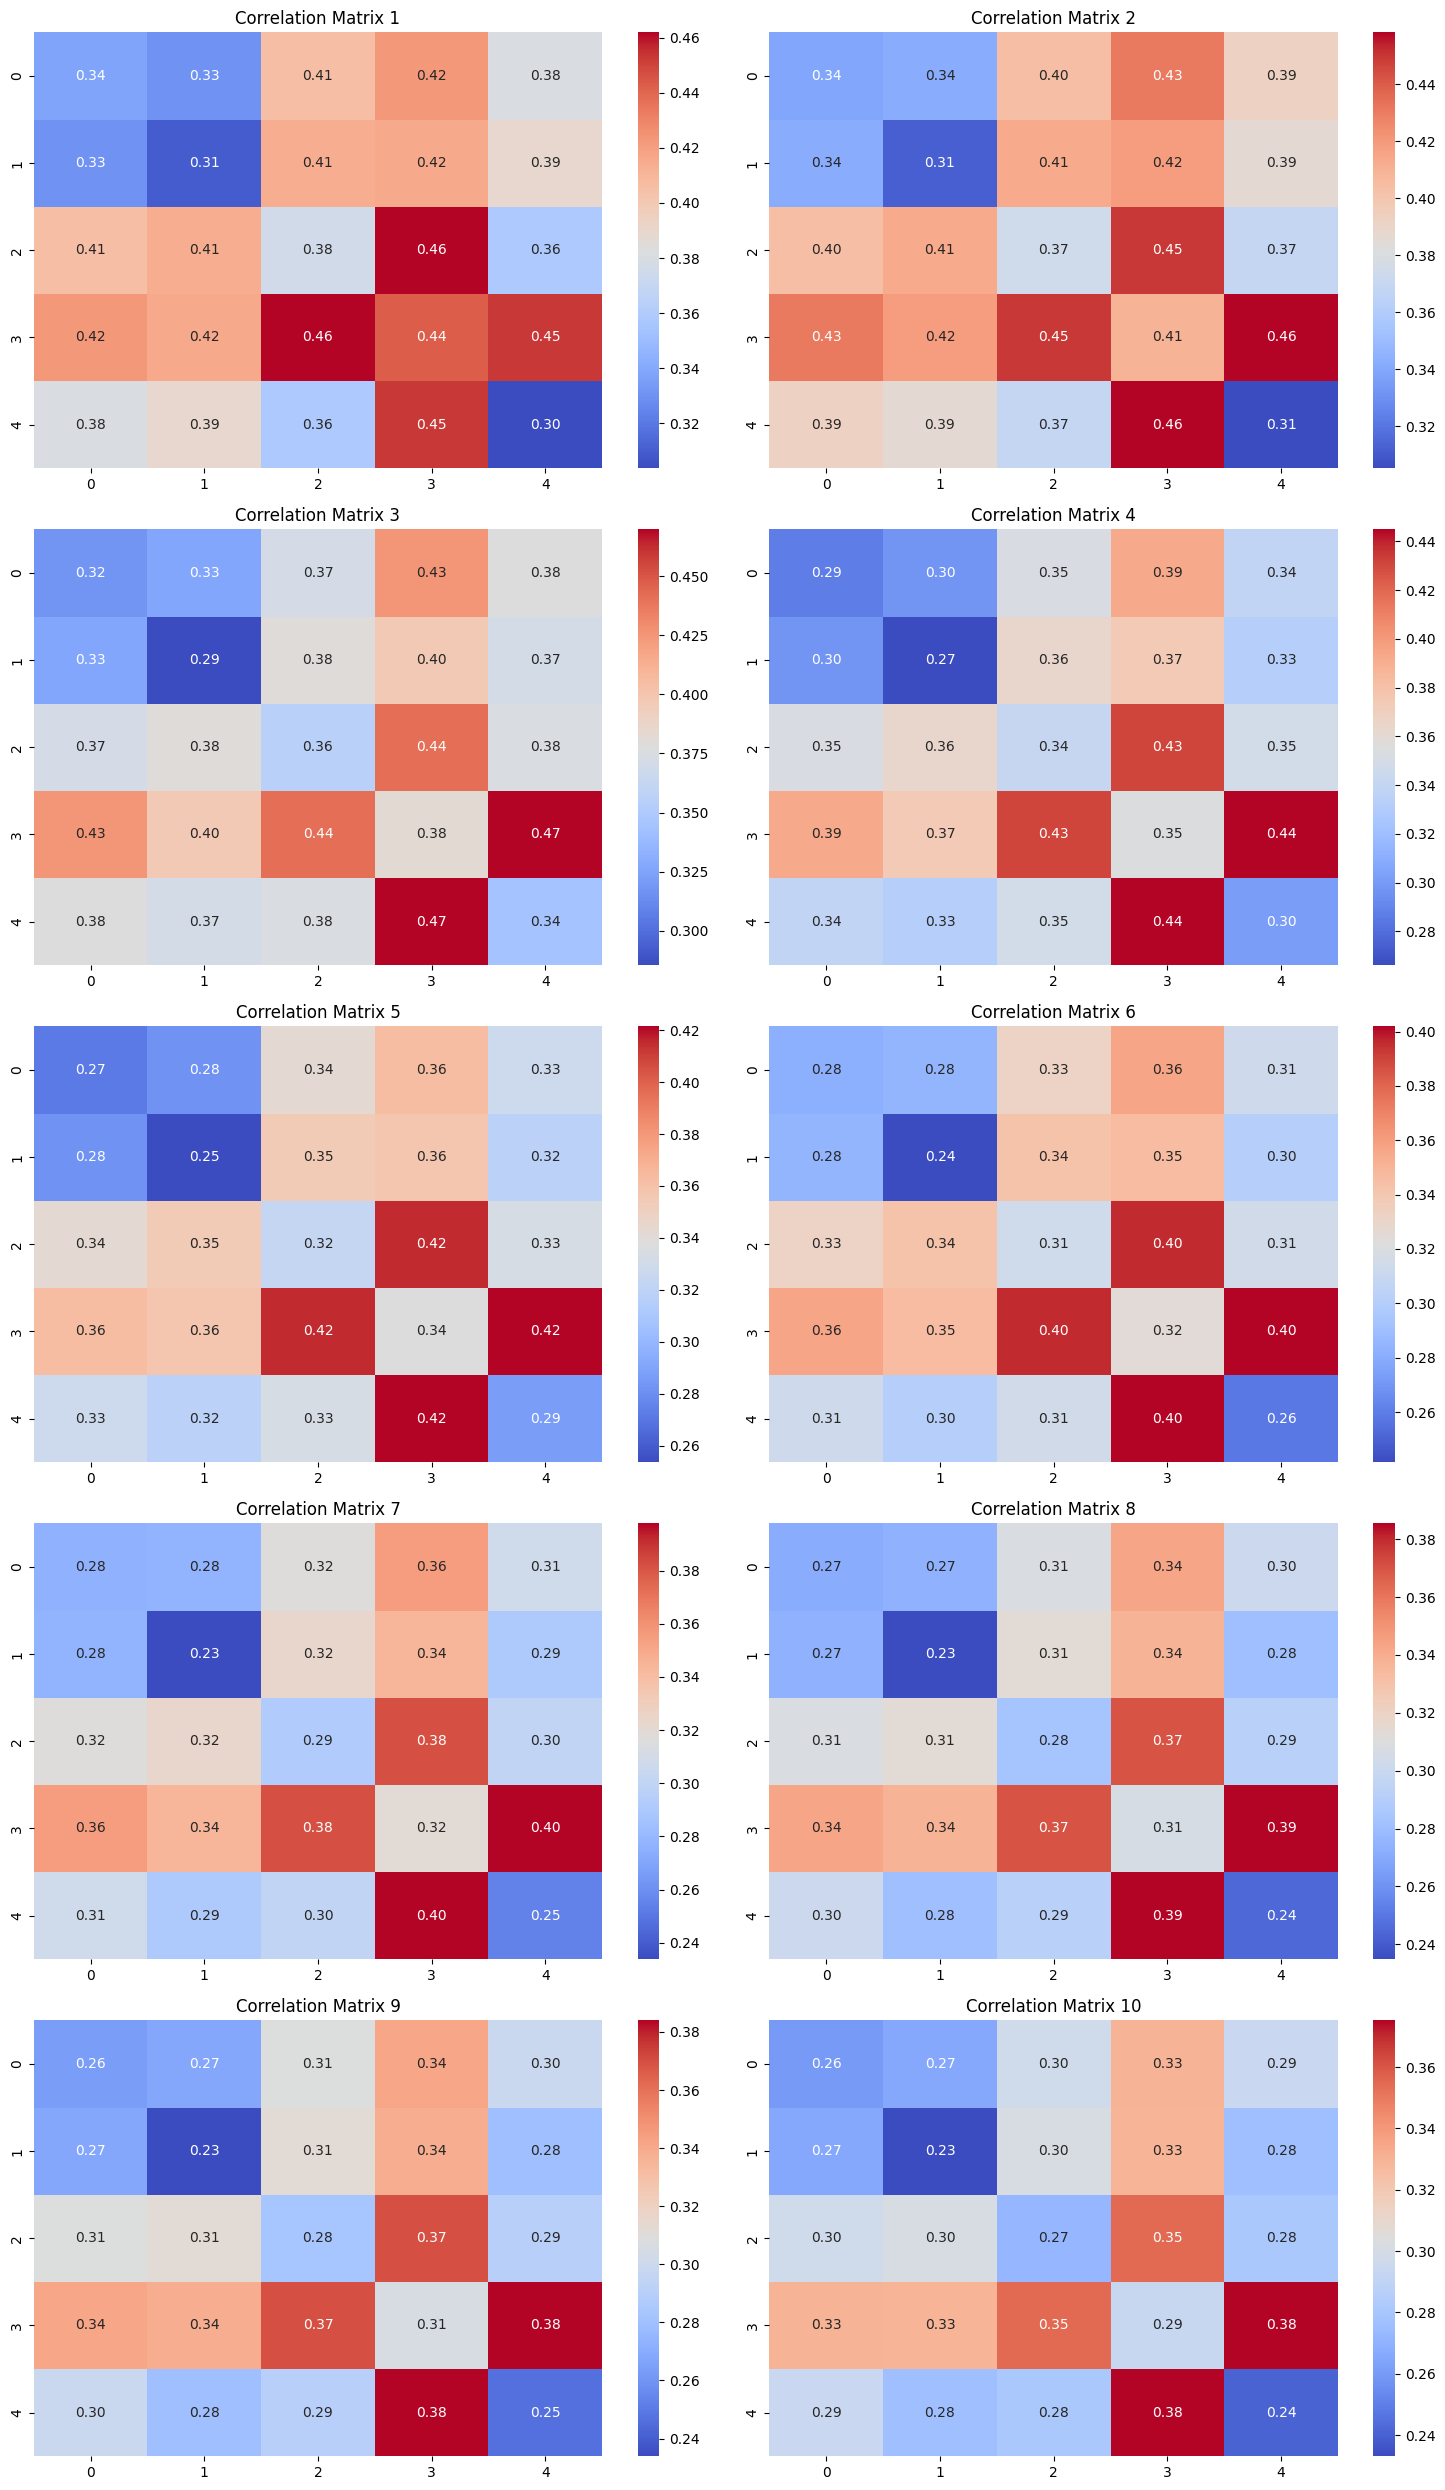

In [33]:
plot_heatmap(corr_glot)

# 4) Model

In [43]:
def model_data(data_folder,num_speakers=5,num_frames=1000,frame_length_msec=30,sr=44100,verbose=True,iteration=1):
    x_glot=[]
    x_vt=[]
    y_vt=[]
    y_glot=[]
    
    total_speaker = 0
    for speaker in os.listdir(data_folder):
        curr_time=0
        req_time=num_frames*frame_length_msec
        
        y=[]
        wav_files=os.listdir(os.path.join(data_folder, speaker))
        idx=0
        while curr_time<req_time:
            if wav_files[idx].endswith(".wav"):
                wav_file_path = os.path.join(data_folder, speaker, wav_files[idx])

                y_curr, sr = librosa.load(wav_file_path, sr=sr)
                
                non_silent_intervals = librosa.effects.split(y_curr, top_db=10)  # 20 dB threshold can be adjusted
                y_non_silent = []
                begin=0
                for start, end in non_silent_intervals:
                    if start-begin<(50*sr//1000):
                        y_non_silent.extend(y_curr[begin:start])
                        
                    y_non_silent.extend(y_curr[start:end])
                    begin=start
        
                y.extend(y_non_silent)
                
                curr_time=math.floor(len(y)*1000/sr)
#                 print(f'curr : {curr_time} req : {req_time}')
                idx+=1
                
        del wav_files
                
        frame_length_samples=frame_length_msec*sr//1000
        frames = librosa.util.frame(y, frame_length=frame_length_samples, hop_length=frame_length_samples).T
        frames=frames[:num_frames]
        del y#,y_normalized

        for frame in frames:
            vt,glot=mfcc_to_vocal_tract_envelope_time_domain(frame,iteration)
            x_vt.append(encode_audio_signal(vt))
            x_glot.append(encode_audio_signal(glot))
            y_vt.append(speaker)
            y_glot.append(speaker)

            del vt,glot

        del frames
                        
        total_speaker += 1
        if total_speaker != 0 and total_speaker % 1 == 0 and verbose:
            print(f"{total_speaker} speakers completed.\n")

        if total_speaker == num_speakers:
            break
    
    return x_vt,x_glot,y_vt,y_glot

In [44]:
num_speakers=25
frame_length_msec=40
num_frames=1000
data_folder="/kaggle/input/speaker-recognition-audio-dataset/50_speakers_audio_data"

In [45]:
x_vt,x_glot,y_vt,y_glot=model_data(data_folder,num_speakers,num_frames,frame_length_msec)

[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1600) too large for available bit count (1568)
[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (2176) too large for available bit count (1568)


1 speakers completed.

2 speakers completed.

3 speakers completed.

4 speakers completed.

5 speakers completed.

6 speakers completed.

7 speakers completed.

8 speakers completed.

9 speakers completed.

10 speakers completed.

11 speakers completed.

12 speakers completed.

13 speakers completed.

14 speakers completed.

15 speakers completed.

16 speakers completed.

17 speakers completed.

18 speakers completed.

19 speakers completed.



[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (2688) too large for available bit count (1568)


20 speakers completed.

21 speakers completed.

22 speakers completed.

23 speakers completed.

24 speakers completed.



[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1632) too large for available bit count (1568)


25 speakers completed.



In [46]:
dict={}
i=0

unique=[]
for val in y_vt:
    if val not in unique:
        unique.append(val)

for val in unique:
    dict[val]=i
    i+=1

dict

{'Speaker0043': 0,
 'Speaker_0014': 1,
 'Speaker0029': 2,
 'Speaker0047': 3,
 'Speaker_0009': 4,
 'Speaker0039': 5,
 'Speaker0041': 6,
 'Speaker0026': 7,
 'Speaker_0018': 8,
 'Speaker_0016': 9,
 'Speaker0045': 10,
 'Speaker_0005': 11,
 'Speaker_0010': 12,
 'Speaker0027': 13,
 'Speaker0034': 14,
 'Speaker0037': 15,
 'Speaker_0012': 16,
 'Speaker0049': 17,
 'Speaker_0008': 18,
 'Speaker_0020': 19,
 'Speaker_0021': 20,
 'Speaker0046': 21,
 'Speaker_0006': 22,
 'Speaker0038': 23,
 'Speaker0035': 24}

In [47]:
from sklearn.model_selection import train_test_split

X_train_vt, X_test_vt, y_train_vt, y_test_vt = train_test_split(x_vt,y_vt , 
                                   random_state=104,  
                                   test_size=0.2,  
                                   shuffle=True)

X_train_glot, X_test_glot, y_train_glot, y_test_glot = train_test_split(x_glot,y_glot , 
                                   random_state=104,  
                                   test_size=0.2,  
                                   shuffle=True)

In [48]:
from sklearn.model_selection import train_test_split

X_train_vt, X_test_vt, y_train_vt, y_test_vt = train_test_split(x_vt,y_vt , 
                                   random_state=104,  
                                   test_size=0.2,  
                                   shuffle=True)

X_train_glot, X_test_glot, y_train_glot, y_test_glot = train_test_split(x_glot,y_glot , 
                                   random_state=104,  
                                   test_size=0.2,  
                                   shuffle=True)

In [49]:
i=0
for _ in y_train_vt:
    y_train_vt[i]=dict[y_train_vt[i]]
    i=i+1

i=0
for _ in y_test_vt:
    y_test_vt[i]=dict[y_test_vt[i]]
    i=i+1
    
i=0
for _ in y_train_glot:
    y_train_glot[i]=dict[y_train_glot[i]]
    i=i+1

i=0
for _ in y_test_glot:
    y_test_glot[i]=dict[y_test_glot[i]]
    i=i+1

In [50]:
def dnn_model(input_shape,output_shape):
    input_data = tf.keras.Input(shape=input_shape)
    
    D1 = tfl.Dense(512, activation='relu')(input_data)
    DP1 = tfl.Dropout(0.2)(D1)
    
    D2 = tfl.Dense(256, activation='relu')(DP1)
    DP2 = tfl.Dropout(0.2)(D2)
    
    D3 = tfl.Dense(128, activation='relu')(DP2)
    DP3 = tfl.Dropout(0.2)(D3)
    
    outputs = tfl.Dense(output_shape, activation='softmax')(DP3)
    
    model = tf.keras.Model(inputs=input_data, outputs=outputs)
    return model

In [51]:
model_vt = dnn_model((len(X_train_vt[0]),),num_speakers)
model_vt.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [52]:
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=10, min_lr=0.00001)
history = model_vt.fit(np.array(X_train_vt),np.array(y_train_vt), batch_size=32, epochs=100, validation_data=(np.array(X_test_vt),np.array(y_test_vt)),callbacks=(reduce_lr))

Epoch 1/100
 82/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0295 - loss: 3.2238

I0000 00:00:1727199662.855031     241 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1727199662.870476     241 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


621/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0441 - loss: 3.2047

W0000 00:00:1727199664.517957     242 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.0442 - loss: 3.2043 - val_accuracy: 0.1030 - val_loss: 2.9845 - learning_rate: 0.0010
Epoch 2/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1000 - loss: 2.9780 - val_accuracy: 0.1144 - val_loss: 2.9089 - learning_rate: 0.0010
Epoch 3/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1108 - loss: 2.9134 - val_accuracy: 0.1222 - val_loss: 2.8768 - learning_rate: 0.0010
Epoch 4/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1126 - loss: 2.8950 - val_accuracy: 0.1224 - val_loss: 2.8754 - learning_rate: 0.0010
Epoch 5/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1091 - loss: 2.8905 - val_accuracy: 0.1328 - val_loss: 2.8444 - learning_rate: 0.0010
Epoch 6/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1180 - loss: 2.8670 - val_accuracy: 0.1336 - val_loss: 2.8362 - learning_rate: 0.0010
Epoch 7/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1210 - loss: 2.8555 - val_a

In [53]:
model_glot = dnn_model((len((X_train_glot[0]),),),num_speakers)
model_glot.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [54]:
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=10, min_lr=0.00001)
history = model_glot.fit(np.array(X_train_glot),np.array(y_train_glot), batch_size=32, epochs=300, validation_data=(np.array(X_test_glot),np.array(y_test_glot)),callbacks=(reduce_lr))

Epoch 1/300
 81/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0472 - loss: 3.2128

W0000 00:00:1727199806.275737     243 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


614/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1152 - loss: 2.9404

W0000 00:00:1727199807.811348     243 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.1165 - loss: 2.9344 - val_accuracy: 0.3116 - val_loss: 2.0777 - learning_rate: 0.0010
Epoch 2/300
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3296 - loss: 2.0186 - val_accuracy: 0.4774 - val_loss: 1.5924 - learning_rate: 0.0010
Epoch 3/300
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4299 - loss: 1.7036 - val_accuracy: 0.5256 - val_loss: 1.4081 - learning_rate: 0.0010
Epoch 4/300
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4872 - loss: 1.5107 - val_accuracy: 0.5806 - val_loss: 1.2495 - learning_rate: 0.0010
Epoch 5/300
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5318 - loss: 1.3917 - val_accuracy: 0.5960 - val_loss: 1.2139 - learning_rate: 0.0010
Epoch 6/300
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5646 - loss: 1.2989 - val_accuracy: 0.6168 - val_loss: 1.1220 - learning_rate: 0.0010
Epoch 7/300
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5817 - loss: 1.2336 - val_a